In [71]:
#importing necssary files
from __future__ import division, print_function, unicode_literals
import numpy as np
import pandas as pd 
get_ipython().magic(u'matplotlib inline')
import matplotlib
import math as mt
import matplotlib.pyplot as plt
from matplotlib.mlab import PCA

#printing versions of current packages in use 
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)

#importing the csv file containing data of sensors, sorting them and selecting the required columns
DataFile = pd.read_csv('C:/Users/muneeba/Desktop/THESIS/DataDistributionPCA.csv')
location=DataFile.iloc[:,1:3]
DataSensors=DataFile.iloc[:,4:68]

#converting the sliced data into matrices 
returns = DataSensors[[key for key in dict(DataSensors.dtypes) if dict(DataSensors.dtypes)[key] in ['float64', 'int64']]] 
returns = returns[:65]
returns_arr = returns.as_matrix()[:65]
locations = location[[key for key in dict(location.dtypes) if dict(location.dtypes)[key] in ['float64', 'int64']]] 
locations = locations[:65] 
locations_arr = locations.as_matrix()[:65]

1.12.1
0.22.0
2.2.0


In [72]:
#confirming the selected data i.e. the locations
locations_arr

array([[ 1,  1],
       [ 3,  1],
       [ 5,  1],
       [ 7,  1],
       [ 9,  1],
       [11,  1],
       [13,  1],
       [15,  1],
       [ 1,  3],
       [ 3,  3],
       [ 5,  3],
       [ 7,  3],
       [ 9,  3],
       [11,  3],
       [13,  3],
       [15,  3],
       [ 1,  5],
       [ 3,  5],
       [ 5,  5],
       [ 7,  5],
       [ 9,  5],
       [11,  5],
       [13,  5],
       [15,  5],
       [ 1,  7],
       [ 3,  7],
       [ 5,  7],
       [ 7,  7],
       [ 9,  7],
       [11,  7],
       [13,  7],
       [15,  7],
       [ 1,  9],
       [ 3,  9],
       [ 5,  9],
       [ 7,  9],
       [ 9,  9],
       [11,  9],
       [13,  9],
       [15,  9],
       [ 1, 11],
       [ 3, 11],
       [ 5, 11],
       [ 7, 11],
       [ 9, 11],
       [11, 11],
       [13, 11],
       [15, 11],
       [ 1, 13],
       [ 3, 13],
       [ 5, 13],
       [ 7, 13],
       [ 9, 13],
       [11, 13],
       [13, 13],
       [15, 13],
       [ 1, 15],
       [ 3, 15],
       [ 5, 15

In [73]:
#finding the eucledian distance 
dist=np.linalg.norm(locations_arr, axis=1)

#finding index of the sensor with maximum eucledian dianace
ind1 = np.unravel_index(np.argmax(dist, axis=None), dist.shape)
ind1
np.shape(dist)

(64L,)

In [74]:
#maximum value of eucliedaian distance
maxdis=np.max(dist)
maxdis 

21.213203435596427

In [75]:
#dviding by the maximum value throughout
NormDist=np.divide(dist,maxdis)
NormDist

array([ 0.06666667,  0.1490712 ,  0.24037009,  0.33333333,  0.42687495,
        0.52068331,  0.6146363 ,  0.70867639,  0.1490712 ,  0.2       ,
        0.27487371,  0.35901099,  0.4472136 ,  0.53748385,  0.62893208,
        0.72111026,  0.24037009,  0.27487371,  0.33333333,  0.4055175 ,
        0.48534066,  0.56960025,  0.65659052,  0.74535599,  0.33333333,
        0.35901099,  0.4055175 ,  0.46666667,  0.53748385,  0.6146363 ,
        0.69602043,  0.78031333,  0.42687495,  0.4472136 ,  0.48534066,
        0.53748385,  0.6       ,  0.66999171,  0.74535599,  0.82462113,
        0.52068331,  0.53748385,  0.56960025,  0.6146363 ,  0.66999171,
        0.73333333,  0.80277297,  0.8768631 ,  0.6146363 ,  0.62893208,
        0.65659052,  0.69602043,  0.74535599,  0.80277297,  0.86666667,
        0.93571126,  0.70867639,  0.72111026,  0.74535599,  0.78031333,
        0.82462113,  0.8768631 ,  0.93571126,  1.        ])

In [76]:
#multiplying by lambda to scale the parameter for geographical location
#let lambda is 0.5 
DistParameter=np.multiply(0.5,NormDist)
DistParameter

array([ 0.03333333,  0.0745356 ,  0.12018504,  0.16666667,  0.21343747,
        0.26034166,  0.30731815,  0.35433819,  0.0745356 ,  0.1       ,
        0.13743685,  0.17950549,  0.2236068 ,  0.26874192,  0.31446604,
        0.36055513,  0.12018504,  0.13743685,  0.16666667,  0.20275875,
        0.24267033,  0.28480012,  0.32829526,  0.372678  ,  0.16666667,
        0.17950549,  0.20275875,  0.23333333,  0.26874192,  0.30731815,
        0.34801022,  0.39015666,  0.21343747,  0.2236068 ,  0.24267033,
        0.26874192,  0.3       ,  0.33499585,  0.372678  ,  0.41231056,
        0.26034166,  0.26874192,  0.28480012,  0.30731815,  0.33499585,
        0.36666667,  0.40138649,  0.43843155,  0.30731815,  0.31446604,
        0.32829526,  0.34801022,  0.372678  ,  0.40138649,  0.43333333,
        0.46785563,  0.35433819,  0.36055513,  0.372678  ,  0.39015666,
        0.41231056,  0.43843155,  0.46785563,  0.5       ])

In [77]:
#now adding the data part for ths algorithum
corr_mat=np.corrcoef(returns_arr,rowvar=True)
corr_mat.shape

#covariance matrix 
cov_mat = np.cov(returns_arr)
cov_mat.shape
 
 

(64L, 64L)

In [78]:

#similarity matrix M 
Similarity=np.subtract(corr_mat,DistParameter)
Similarity.shape
np.shape(corr_mat)

(64L, 64L)

{'color_list': ['g',
  'g',
  'g',
  'r',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'b',
  'b'],
 'dcoord': [[0.0, 0.11122316485337037, 0.11122316485337037, 0.0],
  [0.0, 0.11425569509219224, 0.11425569509219224, 0.0],
  [0.11122316485337037,
   0.13534039825565761,
   0.13534039825565761,
   0.11425569509219224],
  [0.0, 0.023988167103803495, 0.023988167103803495, 0.0],
  [0.0, 0.13373259908044111, 0.13373259908044111, 0.0],
  [0.0, 0.076864273469538502, 0.076864273469538502, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.11281962683859577, 0.11281962683859577, 0.0],
  [0.0, 0.125038982721389

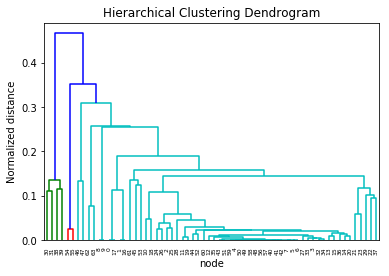

In [79]:
#building hierical dandogram for visualization
from scipy.cluster.hierarchy import dendrogram, linkage

# Calculate the distance between each sample
# You have to think about the metric you use (how to measure similarity) + about the method of clusterization you use 
Z = linkage(returns)

# Make the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('node')
plt.ylabel('Normalized distance')
dendrogram(Z, labels=returns.index, leaf_rotation=90)

In [80]:
cov_mat # covariance matrix
np.shape(cov_mat) #64L by 64L
corr_mat #corelstaion matrix
np.shape(corr_mat) #64L by 64L

(64L, 64L)

In [81]:
#jacobi function
#Input:     input covariance matrix,   correlation coeffs, masked components
#Output:   covariance of rotated data,  correlation coefficients for rotated data,      part of Jacobi rotation; rotation angle
#indices of components that are rotated,      highest correlation,      correlation coefficient for pair
# Description: Picks the two components with highest correlation coefficient. Decorrelate the two components with PCA
# maskno = components which have been already masked by this algo
     
    
from numpy import linalg as LA
global R

count =0
 

def newJacobi(C,cc,maskno):
    if (np.any(C)):
        count= +1
        if (np.any(cc)):
            count+=1
            if (maskno):
                count+=1
                 
    
     
   # maskno=np.array([]) #creating an empty array for masked components
     
    tri=np.triu(cc) #extract the uppar triangular of covariance matrix
    a=0
    if (maskno==[]):
        a=maskno[0]
    else:
        a=0
    tri[a,:]=-1
    tri[:,a]=-1  
    ind = tri.argmax(0)
    no1=ind[0]
    no2=ind[1]
    compno = [no1,no2]
    maxcc=cc[no1][no2]
    cred=np.zeros((2,2))
    cred[0][0]=C[no1][no1]
    cred[0][1]=C[no1][no2]
    cred[1][0]=C[no2][no1]
    cred[1][1]=C[no2][no2]
    if (cred[0][1]==0): # this means that already we have found diagnoal matrix
        Cnew=C
        ccnew=cc
        R=np.identity(2)
        theta=0
        idx=np.array([1,2])
    else:
        c11=cred[0][0]
        c12=cred[0][1]
        c21=cred[1][0]
        c22=cred[1][1]
        R=np.zeros((2,2))
        theta = 1/2 *(mt.atan(2*c12/(c11-c22)))
        cs=mt.cos(theta)
        sn=mt.sin(theta)
        R[0][0] =  cs
        R[0][1] = (-1)*sn
        R[1][0] = sn 
        R[1][1] = cs
        M=C
        Rtrans=R.T
        M[no1][no1]=Rtrans[0][0]*C[no1][no1]
        M[no1][no2]=Rtrans[0][1]*C[no1][no2]
        M[no2][no1]=Rtrans[1][0]*C[no2][no1]
        M[no2][no2]=Rtrans[1][1]*C[no2][no2]
        Cnew=M
        Cnew[no1][no1]=M[no1][no1]*R[0][0]
        Cnew[no1][no2]=M[no1][no2]*R[0][1]
        Cnew[no2][no1]=M[no2][no1]*R[1][0]
        Cnew[no2][no2]=M[no2][no2]*R[1][1]
        if (c11<c22):
            idx=np.array([2,1])
        else:
            idx=np.array([1,2])
        
        dnew=np.diag(Cnew)
        dnewT=dnew.T
        temp1=dnew[no1]*dnewT[no1]
        temp2=dnew[no2]*dnewT[no1]
        temp=temp1+temp2
        temp=mt.sqrt(temp)
        ccnew=cc
        ccnew[no1][:]=Cnew[no1][:]/temp
        ccnew[no2][:]=Cnew[no2][:]/temp #ccnew is 64 by 64  
        
    
   
    return  Cnew,ccnew,R,theta,compno,maxcc,idx

In [82]:
# Build a hierical clustering tree
# inputs: covariance matrix, correlation coeffs,   maxlevel  
# outputs: positions of the two clusters merged, Element T{k} in the cell array contains a 2-by-2 rot matrix , ID of prinicipal 
# components,   all_nodes,   node labels,   theta ,    rotation angles that decorrelates inputs,   PC_ratio
#ratio C_qq/C_pp , hierarchical cluster tree,  labels of the d-components in the comp,updaated covariance matrix,correlation  


import sys
global count1 
count1=0
dim=64 #no od rows od covarince matrix
dim2=64 #no. of columns od covaraince matrix

def Build_JTree(C,cc,maxlevel):
    
           
     
    if (np.any(C)):
        count1= +1
        if (np.any(cc)):
            count1+=1
            if (maxlevel):
                count1+=1
                 
                       
  
            
     
             
    J=maxlevel-1    
    Z = np.zeros((J,3))   # columns 1 and 2 contain the indices of the nodes that are merged
    T = np.ones((2,2))  # 2-by-2 rotation matrices for levels L=0,1,..,J-1
    theta = np.zeros((J,1)) #rotation angles
    PCidx=np.zeros((J,2))  # order of principal components, [1 2] or [2 1]
        
    L=0
    maskno=np.array([]) #0L
    nodes=np.zeros((1,64)) #1L by 64L
    dlabels=np.zeros((1,dim)) #1L by 64L
    PC_ratio=np.zeros((dim-1,1)) #63L by 1L
    Zpos=np.zeros((J,2)) #19L by 2L
    all_d=np.zeros((J,dim)) #19L by 64L
    all_nodes=np.zeros((J,dim)) #19L by 64L
    
    
    for lev in range (J-1):
        [Cnew,ccnew,R,th,compno,maxcc,idx]=newJacobi(C,cc,maskno)
        dist = (1-maxcc)/2
        no1=compno[0]
        no2=compno[1]
        Zpos[:][lev]=dist
        Zpos[no1][:]=nodes[0][no1]
        Zpos[no2][:]=nodes[0][no2]
        T=R
        theta[lev]=th
        PCidx[lev][:]=idx
        C=Cnew
        cc=ccnew
        component1=idx[0]
        component2=idx[1]
        pind=[component1,component2]
        p1=pind[0]
        p2=pind[1]
        nodes[0][p1]=np.array([dim+lev])
        nodes[0][p2]=np.array([dim+lev])
        dlabels[0][p2]=np.array((lev)) #abels of d-components in vector
        maskno=[maskno,p2]
        PC_ratio[lev]=C[p2][p2]/C[p1][p1]
        Zpos[lev][:] =np.array(compno) # their positions in the component vector
        transdlabels=dlabels.T
        all_d[lev][:]=transdlabels[0]
        all_nodes[lev][:]=nodes 
        
    return  Zpos,T,PCidx,maxlevel,all_nodes,Cnew,nodes

In [83]:
maxlevel=5
[Zpos,T,PCidx,maxlev,all_nodes,Cnew,nodes]=Build_JTree(cov_mat,corr_mat,maxlevel)
all_nodes

np.shape(all_nodes)
type(Zpos)
np.shape(Zpos)
Zpos
    


array([[  0.,   0.],
       [ 65.,  65.],
       [  0.,   1.],
       [  0.,   0.]])

{'color_list': ['g',
  'g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'b'],
 'dcoord': [[0.0, 0.0038948243125986283, 0.0038948243125986283, 0.0],
  [0.0, 0.0043198824952160467, 0.0043198824952160467, 0.0],
  [0.0038948243125986283,
   0.0047818358023694633,
   0.0047818358023694633,
   0.0043198824952160467],
  [0.0, 0.00092066861309353322, 0.00092066861309353322, 0.0],
  [0.0, 0.0042212163562760112, 0.0042212163562760112, 0.0],
  [0.0, 0.0027393822197870612, 0.0027393822197870612, 0.0],
  [0.0, 1.7889367930563386e-18, 1.7889367930563386e-18, 0.0],
  [0.0, 0.0042143645836763702, 0.0042143645836763702, 0.0],
  [0.

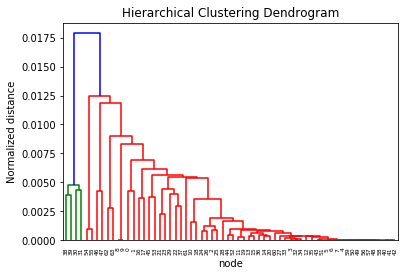

In [84]:
Z1 = linkage(Cnew)
# Make the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('node')
plt.ylabel('Normalized distance')
dendrogram(Z1, labels=returns.index, leaf_rotation=90)

In [85]:
#Calculate the basis for the Jacobi tree algorithm
#inputs : hierarchical cluster information, Element T{k} in the cell array contains a 2-by-2 matrix, id of principal components  
# maxlev, node labels
#outputs : Output:   basis(m,m),    sums(J,m),  difs(J,m)  
 
global basis
def JTree_Basis(Zpos,T,PCidx,maxlev,all_nodes,nodes):
    J=np.shape(Zpos[1])
    m=np.shape(all_nodes[0])
    nodes=np.zeros((1,64))
    nodes = all_nodes[0][:]
    nodes= np.nonzero(nodes)
    del all_nodes
    tmpfilts=np.diag(np.ones(m))
    ind=np.zeros(J)
    sums=np.zeros((maxlev,64))
    difs=np.zeros((maxlev,64))
    for lev in range(4):
        d1=Zpos[lev,0:1]
        d1=int(d1)
        if d1<64:
            s=tmpfilts[d1,:]
        else:
            d2=d1-2
            s=tmpfilts[d2,:]
        R=T
        y=(R.T)*s[lev]
        if d1<64:
            tmpfilts[d1,lev]=y[0][1]
        else:
            d2=d1-2
            tmpfilts[d2,lev]=y[0][1]
        t1=PCidx[0][0]
        t2=PCidx[0][1]
        t1=int(t1)
        t2=int(t2)
        y=y[t1:t2,:]
        sums[lev,:]=y[0][0]
        difs[lev,:]=y[0][1]
        
    tmp = [np.diag(np.ones(m)), sums]
    p=np.flipud(difs)
    tt1=nodes[0][0]
           
    basis  = [tmp[tt1], p]
     
    
     
    
    return sums,difs,basis


In [86]:
maxlev=5
sums,difs,basis=JTree_Basis(Zpos,T,PCidx,maxlev,all_nodes,nodes)
np.shape(basis)
b2=basis[1][maxlev-1][:] #
b2

array([ 0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447])

In [96]:
import pandas as pd
import numpy as np
signal=DataFile.iloc[:,4:68]
sparsify= signal.to_sparse()
sparsify
signal.as_matrix()

array([[ 0.189   ,  0.184   ,  0.176   , ...,  0.0105  ,  0.00344 ,
        -0.00337 ],
       [ 0.157   ,  0.153   ,  0.146   , ...,  0.0087  ,  0.00286 , -0.0028  ],
       [ 0.0515  ,  0.0501  ,  0.0479  , ...,  0.00285 ,  0.000934,
        -0.000918],
       ..., 
       [ 0.0614  ,  0.0598  ,  0.058   , ..., -0.0103  , -0.00952 ,
        -0.00872 ],
       [ 0.19    ,  0.185   ,  0.179   , ..., -0.0319  , -0.0294  , -0.027   ],
       [ 0.213   ,  0.207   ,  0.201   , ..., -0.0358  , -0.0331  , -0.0303  ]])

In [97]:
MeanOfData=returns_arr.mean(1)
MeanData=MeanOfData.sum(axis=0)/64
MeanData
VarData=np.var(returns_arr,1)
VarData=VarData.sum(axis=0)/64
VarData
#phie matrix that is the measurement matrix
phie=0.004 * np.random.randn(64) + 0.003
np.shape(phie)

(64L,)

In [98]:
newx=phie.dot(b2.T)
y=np.multiply(newx,sparsify)
print(y)
print(np.shape(y))

             0.2           0.4           0.6           0.8             1  \
0   2.667020e-02  2.596464e-02  2.483574e-02  2.342462e-02  2.159016e-02   
1   2.215461e-02  2.159016e-02  2.060237e-02  1.947348e-02  1.792124e-02   
2   7.267276e-03  7.069719e-03  6.759272e-03  6.364158e-03  5.870266e-03   
3   9.440403e-04  9.186401e-04  8.777176e-04  8.255061e-04  7.620056e-04   
4   8.170394e-05  7.888169e-05  7.337832e-05  6.561715e-05  5.588041e-05   
5   8.819510e-05  8.438507e-05  7.535389e-05  6.194824e-05  4.515589e-05   
6   9.694405e-05  9.271068e-05  8.269172e-05  6.787495e-05  4.924814e-05   
7   4.642590e-05  4.430922e-05  3.965251e-05  3.245580e-05  2.356573e-05   
8   3.697138e-02  3.598360e-02  3.443137e-02  3.245580e-02  2.991578e-02   
9   3.697138e-02  3.598360e-02  3.443137e-02  3.245580e-02  2.991578e-02   
10  1.453455e-02  1.425233e-02  1.358910e-02  1.278476e-02  1.181109e-02   
11  2.328351e-03  2.271906e-03  2.173127e-03  2.032015e-03  1.862680e-03   
12  6.096045

In [99]:
y1=y.to_dense
y1

<bound method SparseDataFrame.to_dense of              0.2           0.4           0.6           0.8             1  \
0   2.667020e-02  2.596464e-02  2.483574e-02  2.342462e-02  2.159016e-02   
1   2.215461e-02  2.159016e-02  2.060237e-02  1.947348e-02  1.792124e-02   
2   7.267276e-03  7.069719e-03  6.759272e-03  6.364158e-03  5.870266e-03   
3   9.440403e-04  9.186401e-04  8.777176e-04  8.255061e-04  7.620056e-04   
4   8.170394e-05  7.888169e-05  7.337832e-05  6.561715e-05  5.588041e-05   
5   8.819510e-05  8.438507e-05  7.535389e-05  6.194824e-05  4.515589e-05   
6   9.694405e-05  9.271068e-05  8.269172e-05  6.787495e-05  4.924814e-05   
7   4.642590e-05  4.430922e-05  3.965251e-05  3.245580e-05  2.356573e-05   
8   3.697138e-02  3.598360e-02  3.443137e-02  3.245580e-02  2.991578e-02   
9   3.697138e-02  3.598360e-02  3.443137e-02  3.245580e-02  2.991578e-02   
10  1.453455e-02  1.425233e-02  1.358910e-02  1.278476e-02  1.181109e-02   
11  2.328351e-03  2.271906e-03  2.173127e-03  

In [105]:
pp=np.mean(y-sparsify,axis=1)#/np.mean(sparsify) 

In [107]:
pp.sum()/64

-0.0033407008914829754

In [101]:
LA.norm(y-sparsify)/LA.norm(sparsify)

0.85888784700905751

---- comparison between sparsed and densed objects have been made but that does not serve the purpose of error. 
what todo
??




In [102]:
error=y-signal

In [95]:
np.savetxt("errortst.csv", error, delimiter=",") 